In [29]:
import numpy as np # linear algebra
import seaborn as sns
sns.set_palette("husl")

import matplotlib.pyplot as plt
PW = 10
PH = 6
plt.rcParams['figure.figsize'] = (PW, PH) 
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

import datetime as dt
from ggplot import *

dir_path = "./Meteorological Data/" 
%matplotlib inline

import os
print(os.listdir(dir_path))

['Melbourne - 086071-Table 1.csv', 'Brisbane - 040913-Table 1.csv', 'Adelaide - 023090-Table 1.csv', 'Perth - 009225-Table 1.csv', 'Sydney - 066062-Table 1.csv']


In [30]:
files = ['Melbourne - 086071-Table 1.csv', 'Brisbane - 040913-Table 1.csv',
         'Adelaide - 023090-Table 1.csv', 'Perth - 009225-Table 1.csv', 'Sydney - 066062-Table 1.csv']

## Preprocessing

In [238]:
#Dict for renamimng columns
name_map= { u'Minimum temperature (°C)':"MinTemp",
                u'Maximum temperature (°C)': "MaxTemp",
                           u'Rainfall (mm)': "Rainfall",
                        u'Evaporation (mm)': "Evaporation",
                        u'Sunshine (hours)': "Sunshine",
         u'Direction of maximum wind gust ': "DirectOfMaxWind", 
       u'Speed of maximum wind gust (km/h)': "SpeedOfMaxWind",
               u'Time of maximum wind gust': "TimeOfMaxWind",
                    u'9am Temperature (°C)': "9am_Temp",
               u'9am relative humidity (%)': "9am_RelHumid",
                u'9am cloud amount (oktas)': "9am_Clouds",
                      u'9am wind direction': "9am_WindDirect",
                   u'9am wind speed (km/h)': "9am_WindSpeed",
                  u'9am MSL pressure (hPa)': "9am_Preassure",
                    u'3pm Temperature (°C)': "3pm_Temp",
               u'3pm relative humidity (%)': "3pm_RelHumid",
                u'3pm cloud amount (oktas)': "3pm_Clouds",
                      u'3pm wind direction': "3pm_WindDirect",
                   u'3pm wind speed (km/h)': "3pm_WindSpeed",
                  u'3pm MSL pressure (hPa)': "3am_Preassure",
                                 u'Quarter': u'Quarter',
                                  "TempVar":"TempVar"}

rev_name_map = {v: k for k, v in name_map.iteritems()}

In [239]:
city = 0
days = 365
df = pd.read_csv(dir_path + files[city], encoding="utf-8")
df["City"] = files[city].split(" ")[0]
df = df[-days:]

for city in range(1, len(files)):
    
    tdf = pd.read_csv(dir_path + files[city], encoding="utf-8")
    tdf = tdf[-days:]
    
    #Drop Unnamed Column
    if city in [1,2,4]:
        tdf.drop([tdf.columns[-1]], axis=1, inplace=True)
    
    tdf["City"] = files[city].split(" ")[0]
    df = pd.concat([df, tdf])
        
#Save Date for plotting
df["DateI"] = pd.to_datetime(df.Date)
df.set_index(df.Date, inplace=True)

#Sort df
df = df.sort_values(["DateI","City"])

#Rename Columns
df.rename(index=str, columns=name_map, inplace=True)

#Add quartals of the year
df["Quarter"] = df.Date.apply(lambda x: pd.Timestamp(x).quarter)
#Infere Season
df["Season"] = df["Quarter"].apply(lambda x: "Q2Q3" if x in[1,4] else "Q4Q1")

#New Columns
df["TempVar"] = df[u"MaxTemp"] - df[u"MinTemp"]

#Fill zeros for Adeleide
df.loc[df.City =="Adelaide", '9am_Clouds'] = 0
df.loc[df.City =="Adelaide", '3pm_Clouds'] = 0

#Drop columns
df.drop(["Day","Date"], axis=1, inplace=True)

print(df.columns)
df.head(3)

Index([u'MinTemp', u'MaxTemp', u'Rainfall', u'Evaporation', u'Sunshine',
       u'DirectOfMaxWind', u'SpeedOfMaxWind', u'TimeOfMaxWind', u'9am_Temp',
       u'9am_RelHumid', u'9am_Clouds', u'9am_WindDirect', u'9am_WindSpeed',
       u'9am_Preassure', u'3pm_Temp', u'3pm_RelHumid', u'3pm_Clouds',
       u'3pm_WindDirect', u'3pm_WindSpeed', u'3am_Preassure', u'City',
       u'DateI', u'Quarter', u'Season', u'TempVar'],
      dtype='object')


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,DirectOfMaxWind,SpeedOfMaxWind,TimeOfMaxWind,9am_Temp,9am_RelHumid,9am_Clouds,9am_WindDirect,9am_WindSpeed,9am_Preassure,3pm_Temp,3pm_RelHumid,3pm_Clouds,3pm_WindDirect,3pm_WindSpeed,3am_Preassure,City,DateI,Quarter,Season,TempVar
Date,,,,,,,,,,,,,,,,,,,,,,,,,
1/1/2014,22.0,33.0,NaN,NaN,0.5,WSW,43.0,13:15,29.8,29.0,0.0,ENE,4.0,1006.1,29.7,50.0,0.0,SSW,24.0,1007.0,Adelaide,2014-01-01,1,Q2Q3,11.0
1/1/2014,20.6,30.6,0.0,3.4,12.5,ENE,31.0,14:18,28.8,52.0,4.0,SE,7.0,1015.2,28.9,52.0,1.0,ENE,11.0,1013.1,Brisbane,2014-01-01,1,Q2Q3,10.0
1/1/2014,16.2,26.3,0.0,10.6,0.0,N,80.0,11:01,21.9,91.0,NaN,N,43.0,1010.1,NaN,NaN,NaN,N,35.0,1003.7,Melbourne,2014-01-01,1,Q2Q3,10.1


##  Fill NaNs

In [240]:
#IsNan Cols#IsNan C 
p = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
p = p[p > 0]
p

3pm_Clouds         0.095342
9am_Clouds         0.076712
Evaporation        0.065753
Rainfall           0.050411
9am_WindSpeed      0.032877
Sunshine           0.006027
DirectOfMaxWind    0.006027
SpeedOfMaxWind     0.006027
TimeOfMaxWind      0.004384
3pm_WindSpeed      0.003288
3pm_RelHumid       0.002192
3pm_Temp           0.001644
9am_Temp           0.001096
9am_RelHumid       0.001096
TempVar            0.001096
9am_Preassure      0.000548
MaxTemp            0.000548
MinTemp            0.000548
dtype: float64

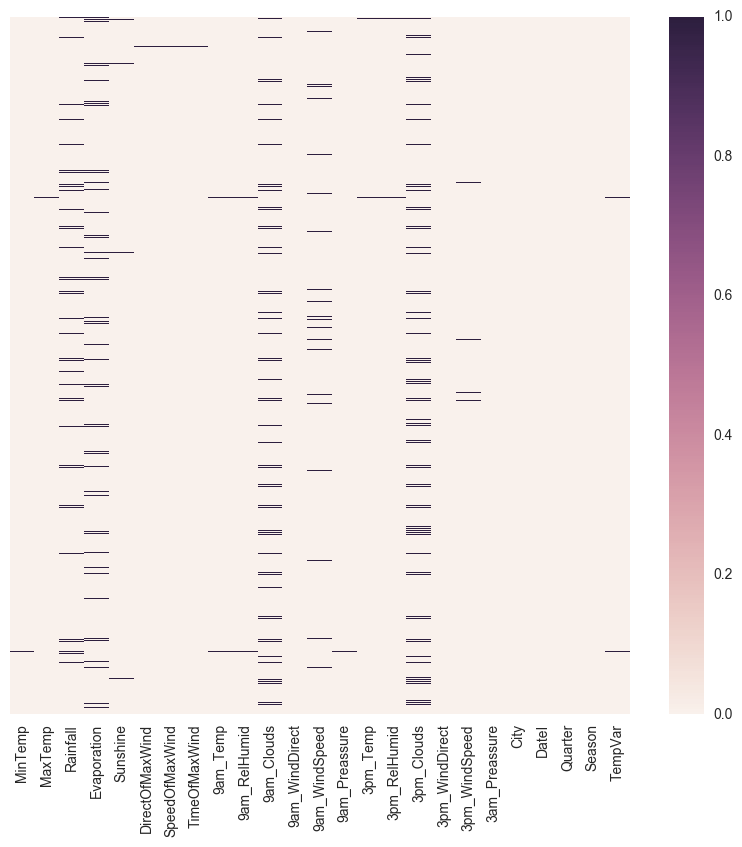

In [241]:
#Plot Nans
f, ax = plt.subplots(1,1,figsize=(PW,1.5*PH))
mnn = pd.DataFrame(np.array(df.isnull().values, dtype='bool')+1-1, columns=df.columns)
sns.heatmap(mnn, ax=ax, yticklabels=False);

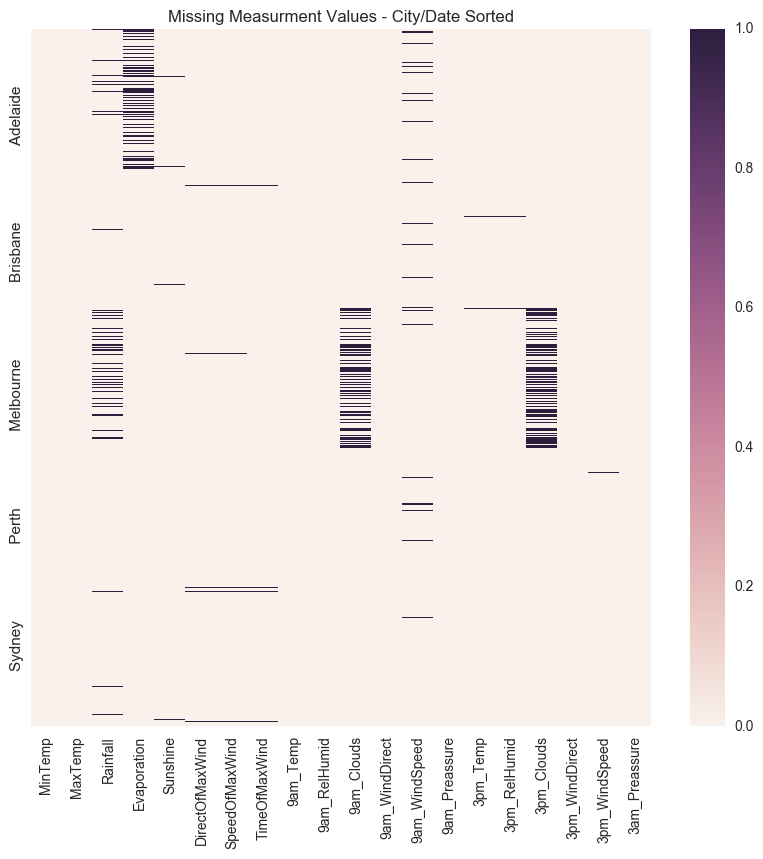

In [242]:
#Plot Nans Per City
f, ax = plt.subplots(1,1,figsize=(PW,1.5*PH))
cols = df.columns[0: len(df.columns) - 5]
topl = df.sort_values(["City","DateI"])[cols]

mnn = pd.DataFrame(np.array(topl.isnull().values, dtype='bool')+1-1, columns=topl.columns)
sns_plt = sns.heatmap(mnn, ax=ax, yticklabels=False);
#print df.groupby("City").sum().index
#Add Ylabels
ax.set_ylabel("                  ".join(['Adelaide', 'Brisbane', 'Melbourne', 'Perth', 'Sydney'][::-1]));

plt.title('Missing Measurment Values - City/Date Sorted')
sns_plt.figure.savefig("./Plots/" + "NaNs.png")

In [243]:
#Fill Group Median/Mode
medCols = p.index
for col in medCols:
    if df[col].dtype != object:
        df[col] = df[col].fillna(df[col].median())
        df[col] = df.groupby(["City","Quarter"])[col].transform(lambda x: x.fillna(x.median()))
    else:
        df[col] = df.groupby(["City","Quarter"])[col].transform(lambda x: x.fillna(lambda y: y.mode()[0]))

## Exploratory Analysis

In [244]:
def plot_dists(df, p):
    nrows = 2
    ncols = int(np.ceil(len(p) / float(nrows)))
    #f, ax = plt.subplots(ncols, nrows, figsize=(nrows*PW,ncols*PH))
    ind = 0
    for col in p:
        if df[col].dtype == object:
            continue
#             topl =  df[df[col].notnull()][col].value_counts()
#             sns.barplot(x=np.array(topl.index), y= np.array(topl.values), ax=ax[int(ind/nrows),ind%nrows])
#             ax[int(ind/nrows),ind%nrows].set_xlabel(col)
#             ind += 1
        elif df[col].dtype != "datetime64[ns]":
            topl = df#[df[col].notnull()][col]
            if len(topl) > 0:
                #sns_plt = sns.violinplot(x="City", y=col, hue="Season" ,split=True, data=df, ax=ax[int(ind/nrows),ind%nrows],palette=pal)
                pal = sns.diverging_palette(20, 200, s=75, l=75, n=2)
                f, ax = plt.subplots(1, 1, figsize=(PW,PH))
                topl = df.rename(index=str, columns=rev_name_map)
                sns_plt = sns.violinplot(x="City", y=rev_name_map[col], hue="Season",split=True, data=topl, palette=pal, ax=ax)
                sns_plt.figure.savefig("./Plots/Dist" + col.replace("/","") + ".png")
                ind += 1
        else:
            continue

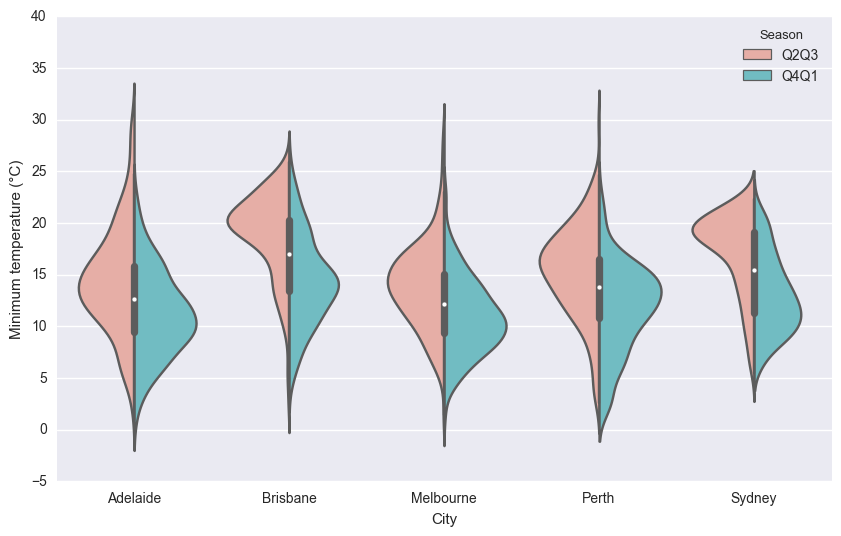

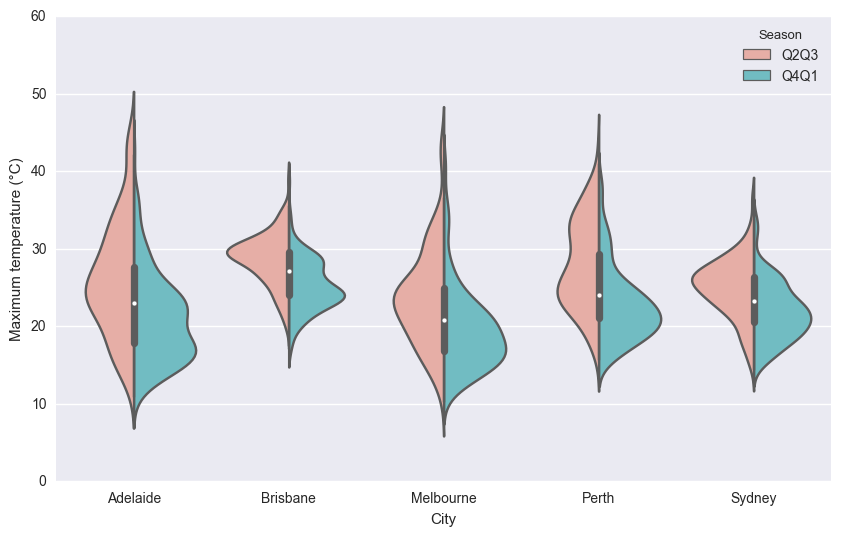

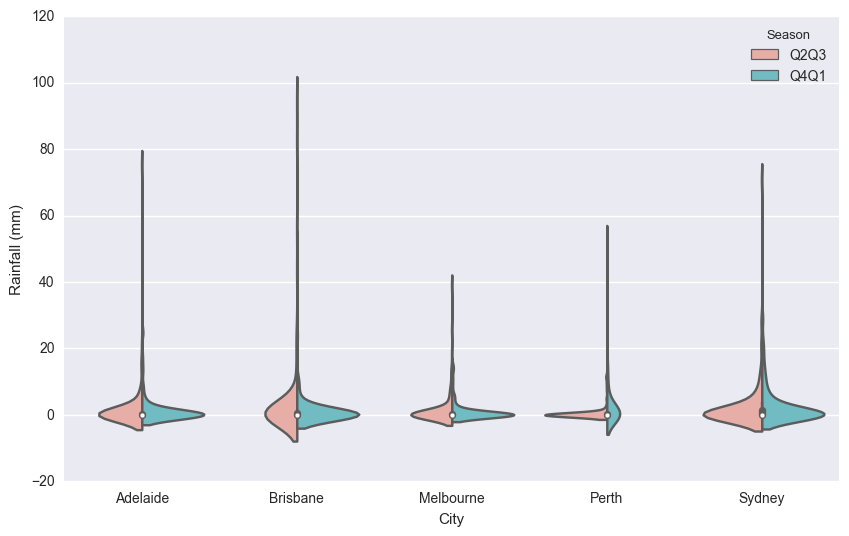

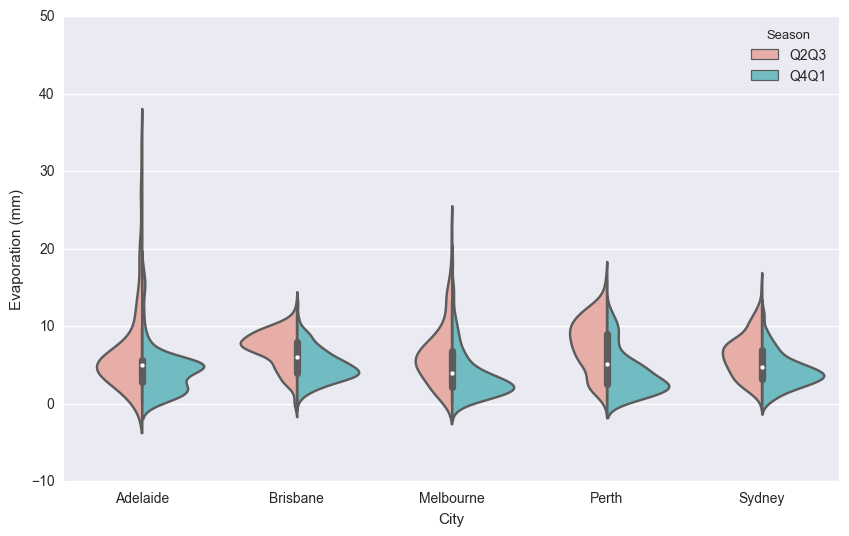

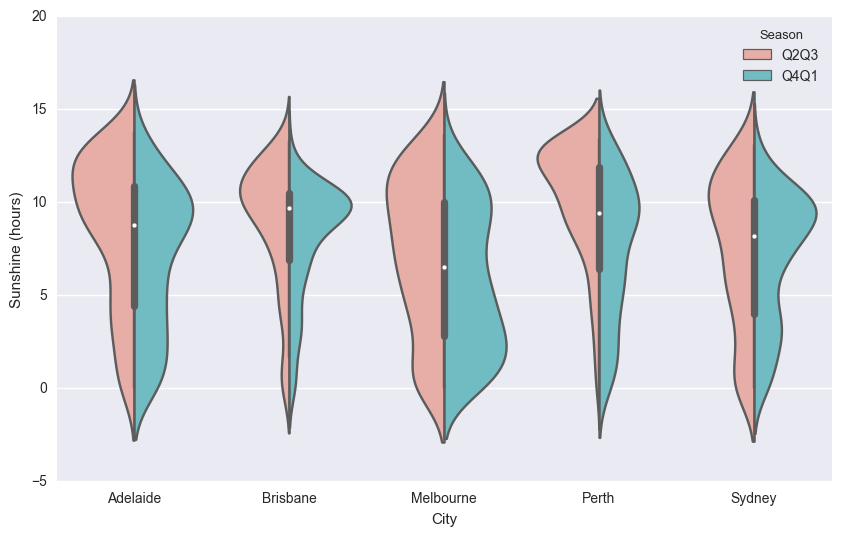

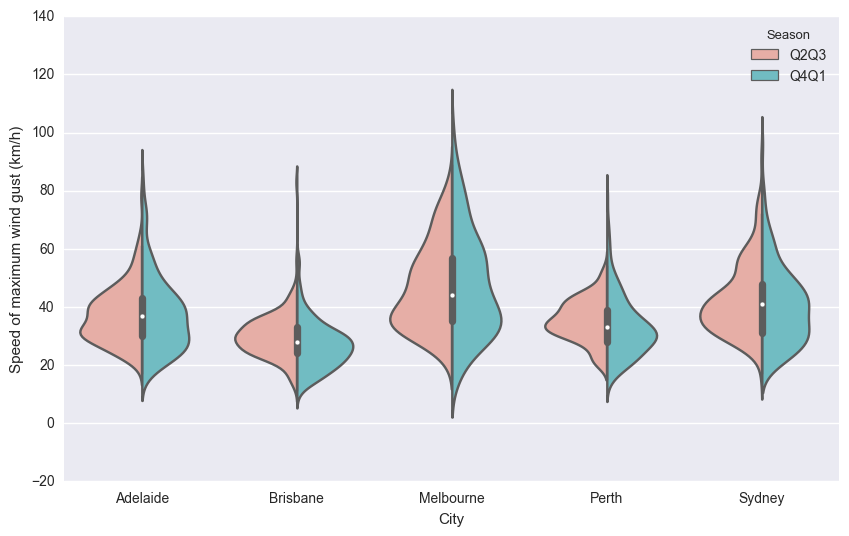

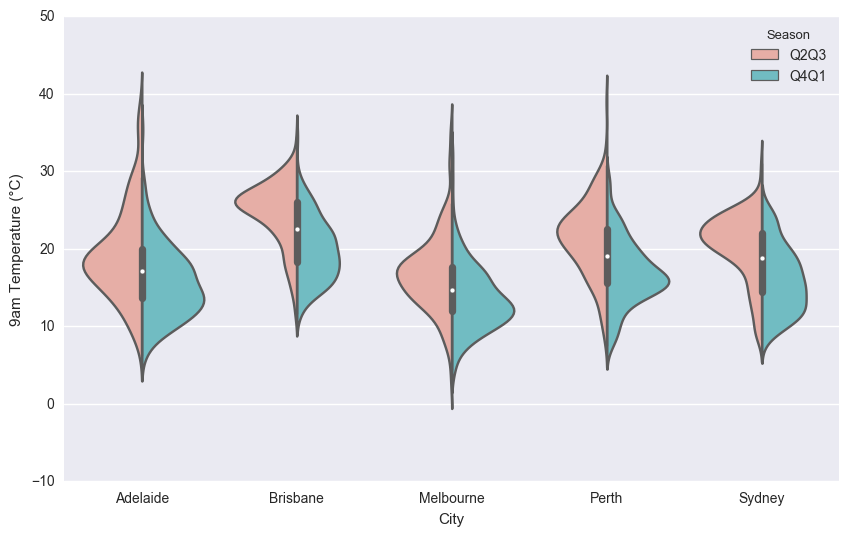

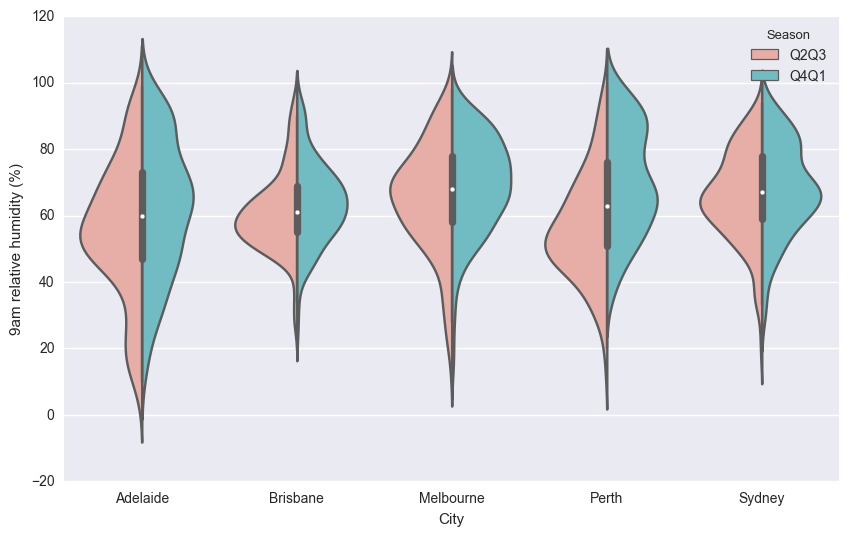

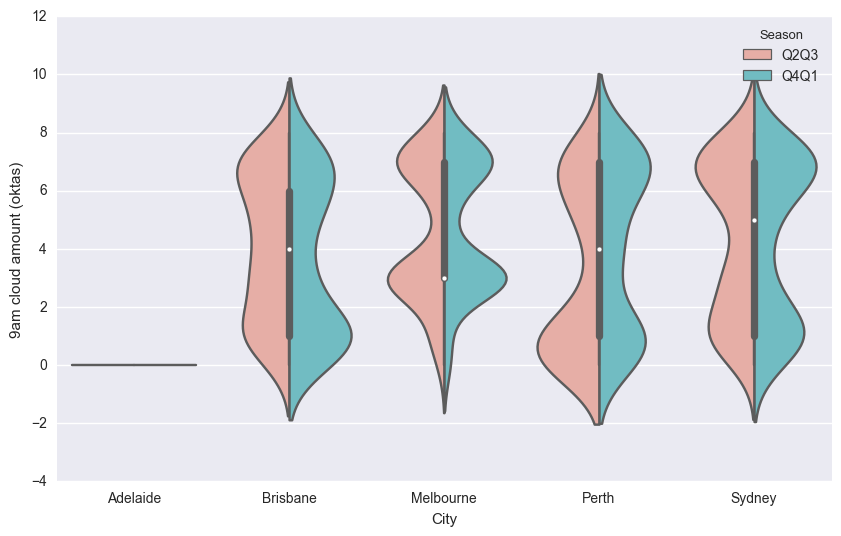

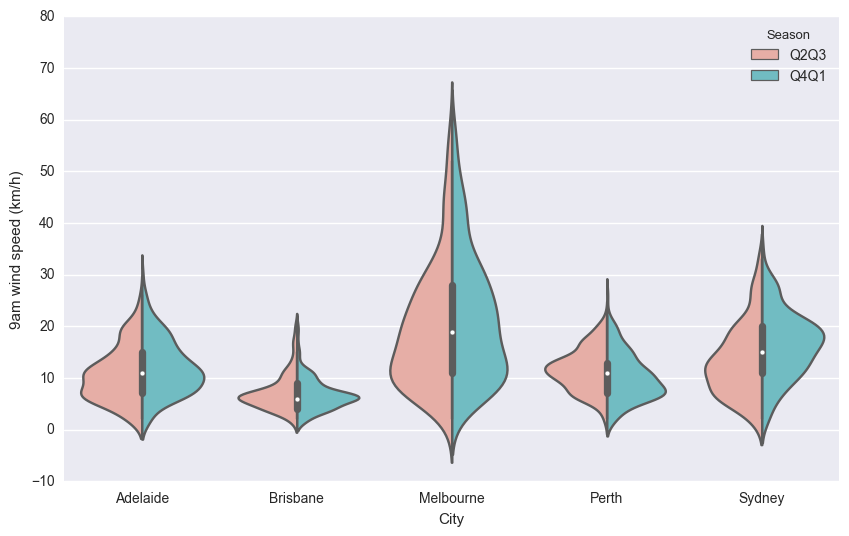

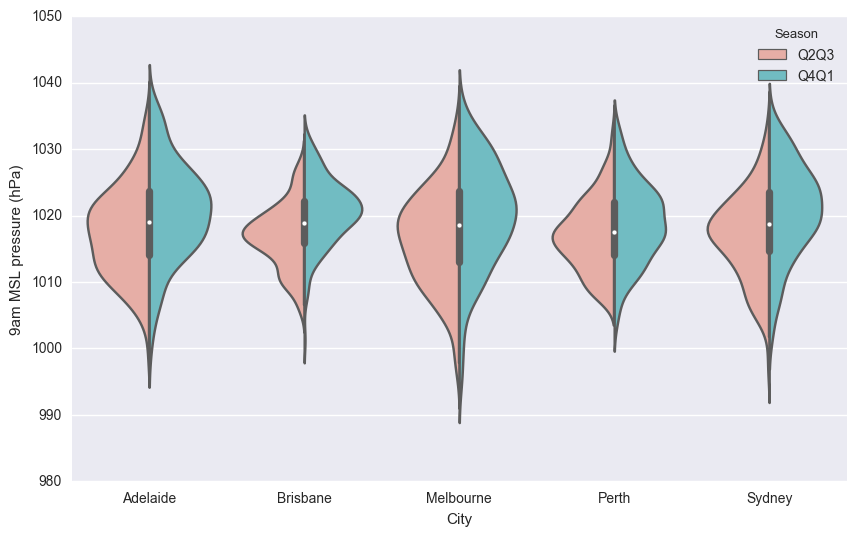

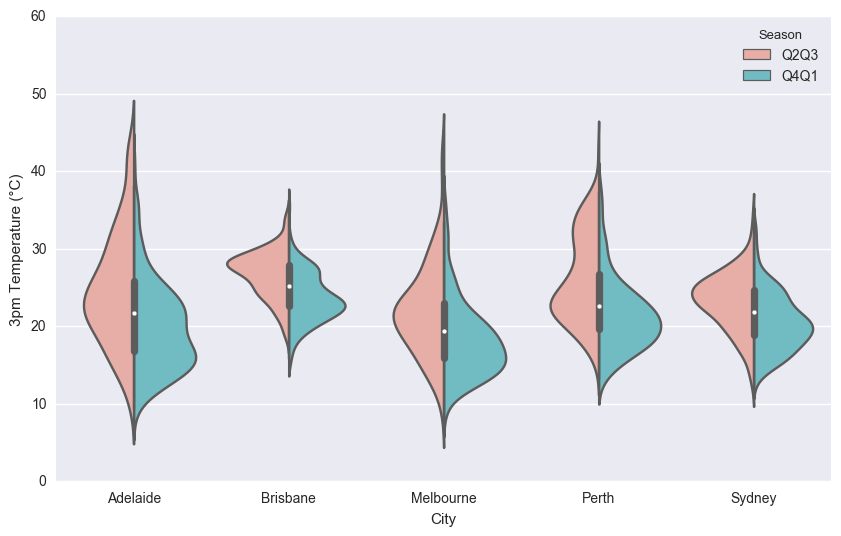

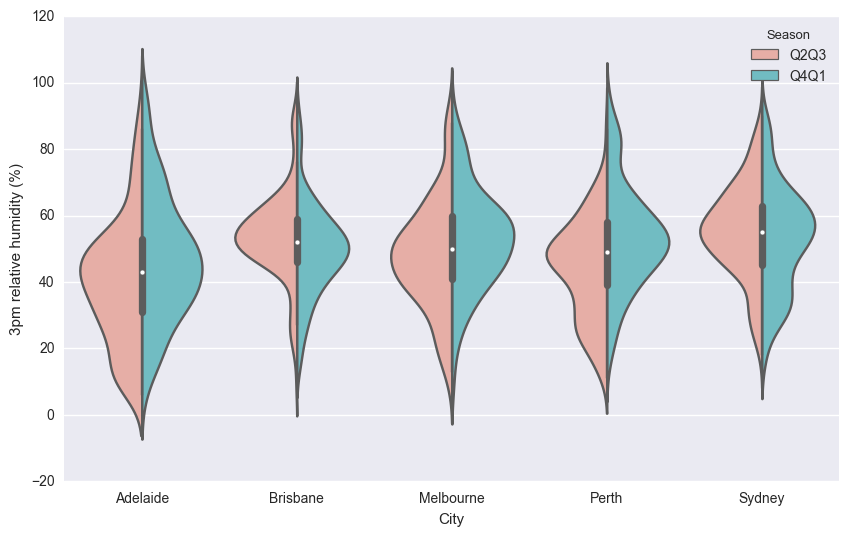

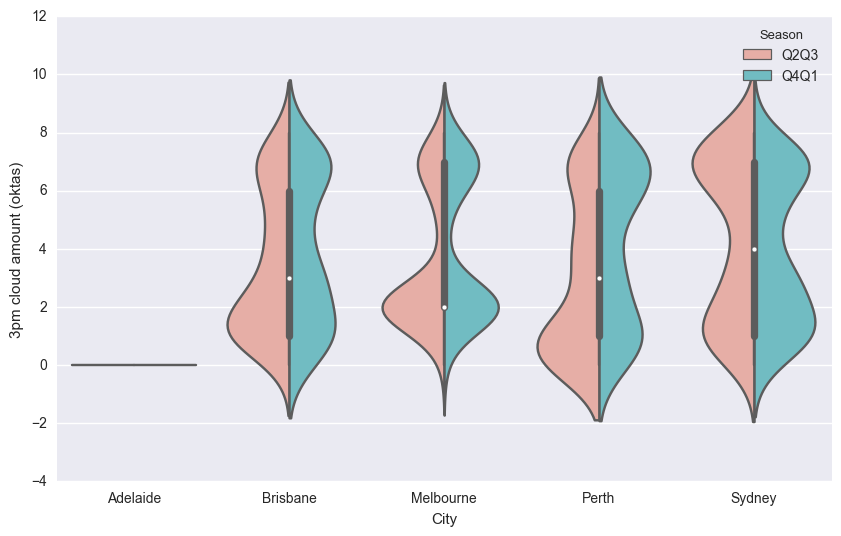

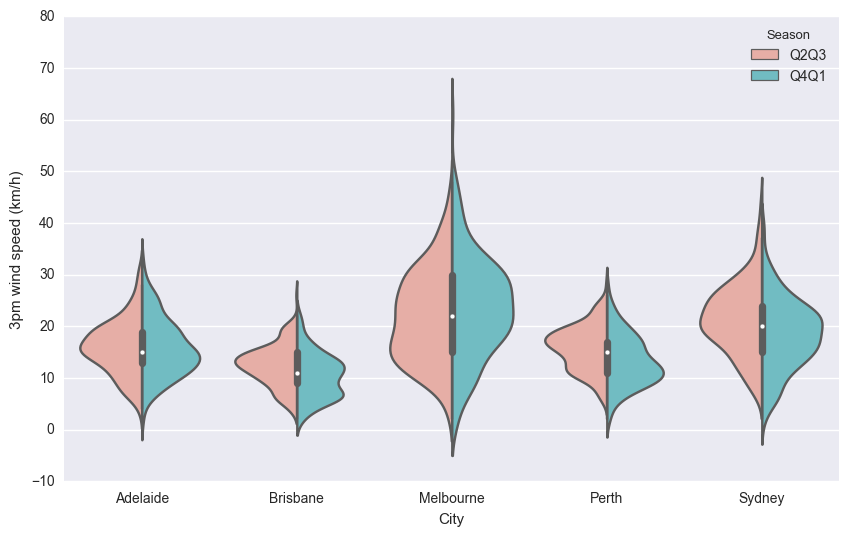

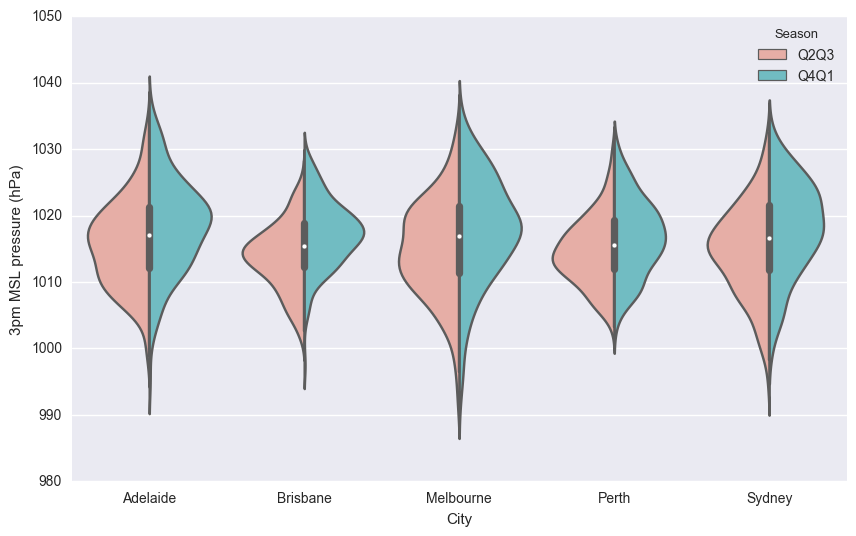

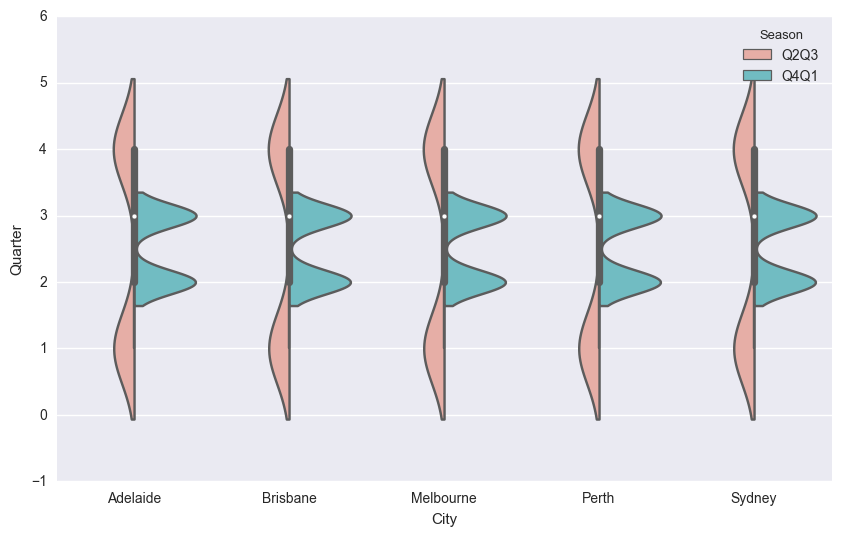

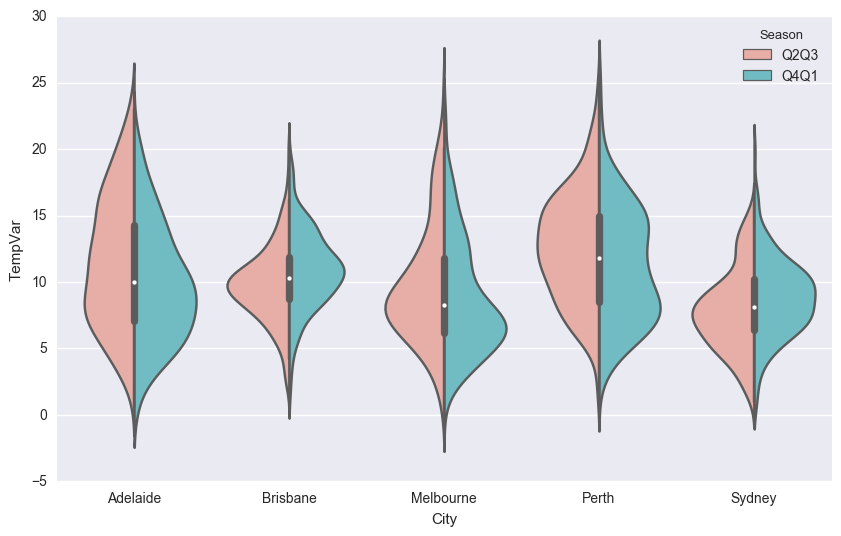

In [245]:
plot_dists(df, df.columns)

## Rainfall

In [247]:
def roll(df, col, roll=10):
    ncol = col + "_MA"
    df[ncol] = df.groupby("City")[col].transform(lambda x: x.rolling(roll).mean())
    df[ncol] = df[ncol].fillna(0)
    return ncol

def cumsumCat(df, col):
    ncol = col + "_CS"
    df[ncol] =  df.groupby(["City"])[col].transform(lambda x: x.cumsum())
    return ncol

def plot_time(topl, col):
    f, ax = plt.subplots(1,1,figsize=(PW,PH)) 
    topl["Unit"] = 0
    sns_plt = sns.tsplot(data=topl, time="DateI",condition="City", unit="Unit", value=col, ax=ax);

    xticks = ax.get_xticks();
    # convert all xtick labels to selected format from ms timestamp
    ax.set_xticklabels([pd.to_datetime(tm).date() for tm in xticks], rotation=50)

    xticks = ax.get_xticks();
    # convert all xtick labels to selected format from ms timestamp
    ax.set_xticklabels([pd.to_datetime(tm).date() for tm in xticks], rotation=50)

    ax.set_xlabel("Date")
    return sns_plt

df.sort_values(["City","Date"]);

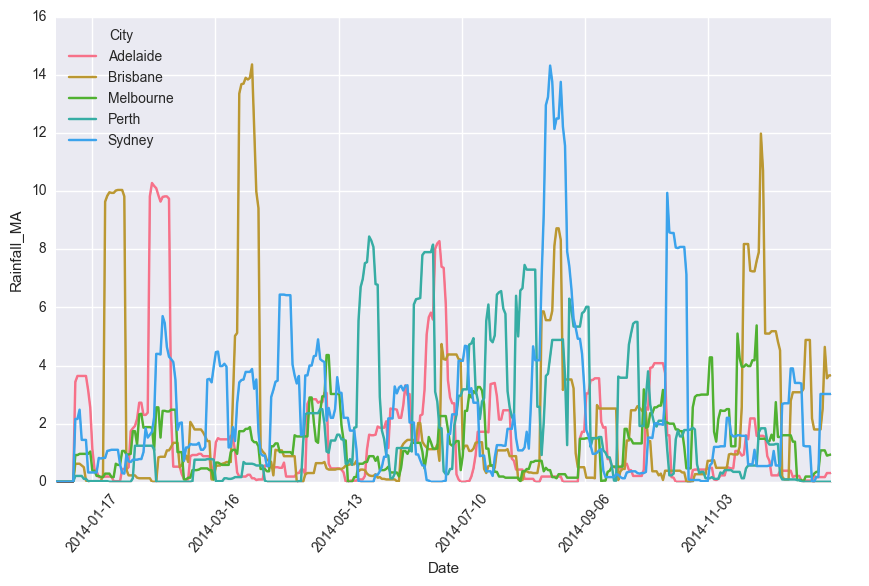

In [248]:
col = "Rainfall"
ncol = roll(df, col, 10)

#Residual
#df[ncol] = df[col] - df[ncol]

topl = df.rename(index=str, columns=rev_name_map)
plot_time(topl, ncol)
sns_plt.figure.savefig("./Plots/" + "RainfallWInter.png")

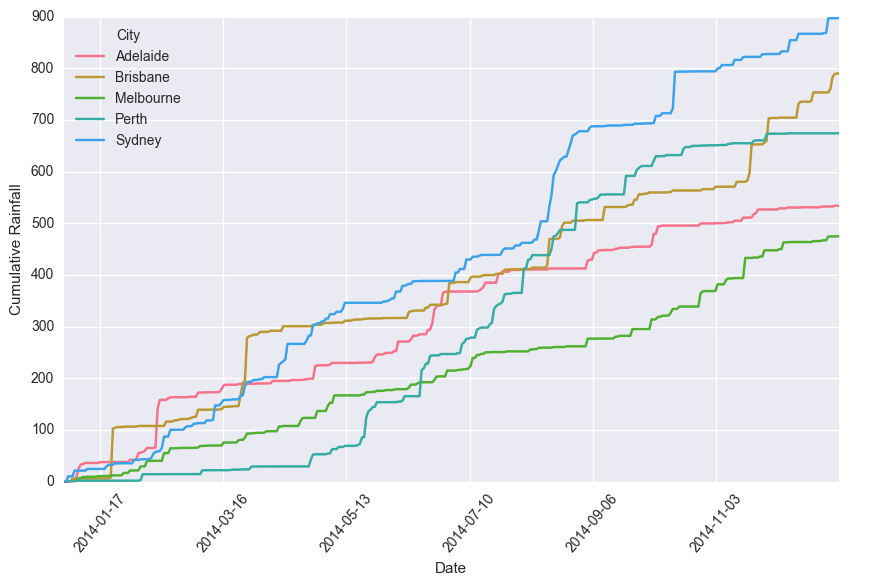

In [249]:
col = "Rainfall"
ncol = cumsumCat(df, col)

topl = df.rename(index=str, columns=rev_name_map)
sns_plt = plot_time(df, ncol)

sns_plt.set_ylabel("Cumulative Rainfall")

sns_plt.figure.savefig("./Plots/" + "CumulativeRainFall.png")

In [ ]:
# col = u'Rainfall (mm)'
# ncol = roll(df, col, 5)
# #Residual
# df[ncol] = df[col] - df[ncol]
# topl = df#[df.Season == "Winter"]
# g = ggplot(topl, aes(x='DateI', y=ncol, color='City')) + \
#         geom_line(size=2.0,alpha=0.7) + \
#         xlab('Date') + \
#         ylab('Precipitation in mms') + \
#         ggtitle('Rainfall during Winter Period - Trend Component')
# g
# g.save("./Plots/Ranfall1.png")

In [ ]:
# topl = df
# g = ggplot(topl, aes(x="DateI", y=ncol, color="City")) + \
#     geom_line() +\
#     xlab('Date') + \
#     ylab('Cumulative sum of Precipitation in mms') + \
#     scale_x_date(labels=None) +\
#     ggtitle('Cumulative Rainfall - Whole Year')
# g
# g.save("./Plots/Ranfall2.png")

## ARIMA Modeling

In [219]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller

In [220]:
def test_stat(series):
    dftest = adfuller(series)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

Test Statistic                -9.505205e+00
p-value                        3.361719e-16
Lags Used                      4.000000e+00
Number of Observations Used    3.600000e+02
Critical Value (5%)           -2.869602e+00
Critical Value (1%)           -3.448646e+00
Critical Value (10%)          -2.571065e+00
dtype: float64


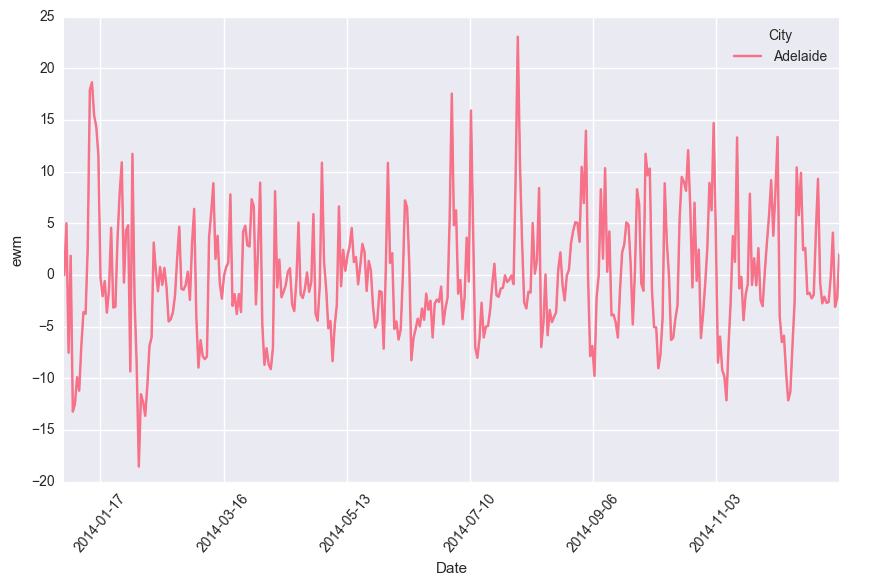

In [221]:
col= u'Maximum temperature (°C)'
city =  "Adelaide"

totst = df[df.City == city].copy()

ncol = "ewm"
totst[ncol] = pd.DataFrame.ewm(totst[col].to_frame(), halflife=10).mean()

totst[ncol] = totst[col] - totst[ncol]

sns_plt = plot_time(totst, ncol);
sns_plt.figure.savefig("./Plots/" + "MinTemp.png")

test_stat(totst[ncol])

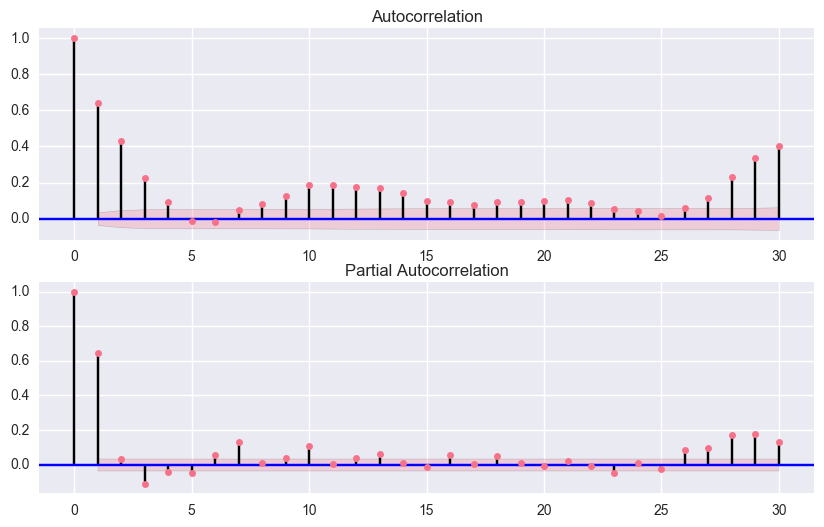

In [222]:
#Test
series = totst[col]

lags = 30
f, ax = plt.subplots(2,1,figsize=(PW,PH)) 
smt.graphics.plot_acf(series, lags=lags, ax=ax[0], alpha=0.5);
smt.graphics.plot_pacf(series, lags=lags, ax=ax[1], alpha=0.5);

In [223]:
# col = u'Maximum temperature (°C)'
# window = 5
# ncol = roll(df, col, window)

# #Residual
# #df[ncol] = df[col] - df[ncol]

# topl = df#[df.Season == "Winter"]
# plot_time(topl, ncol)
# sns_plt.figure.savefig("./Plots/" + "MaxTemp.png")

In [224]:
mdl = smt.AR(series).fit(maxlag=30, ic='aic', trend='nc')
#alpha
mdl.params[0]

/Users/markopetkovic/anaconda/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


0.49141621389165513

In [225]:
mdl = ARMA(series,order=(0,1,2)).fit(maxlag=30, ic='aic', trend='nc')
mdl.params[0]

/Users/markopetkovic/anaconda/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


0.8130437882365957